In [2]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve
PATH = Path('../..').resolve()

seed = 256

# Results from Section 4.3 in nb 01

In [45]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_3.csv')
res.sample(10)

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
38085,903411670000000680,179.782892,1.643552,16.591684,b'nsa13927',0.078766,0,False,False,1,True,0.297445
15703,903323930000003617,146.429465,0.240044,17.542307,b'nsa32',0.190770,0,False,False,1,True,0.287547
24111,916001760000002709,134.861350,54.607340,20.617752,b'nsa135591',0.753509,0,False,False,1,True,0.289156
16082,903326910000001710,220.823766,0.254377,19.388992,b'nsa165536',0.330100,0,False,False,1,True,0.288576
56679,903625980000003301,144.769720,5.616623,20.277277,b'nsa157374',0.579222,0,False,False,1,True,0.288228
74979,903454920000004811,181.192996,2.591099,19.863604,b'nsa13927',0.047234,0,False,False,1,True,0.387337
44122,902548960000004538,55.555155,-13.361067,19.136196,b'nsa133549',0.173599,0,False,False,1,True,0.286854
82134,903262040000000721,39.019509,-0.669421,22.331486,b'nsa132339',1.258673,0,False,False,1,True,0.292323
26457,916168650000000383,228.381249,59.869494,21.892038,b'nsa165980',0.684000,0,False,False,1,True,0.288795
77756,902844460000005491,9.294218,-7.908595,20.574965,b'nsa127226',0.613536,0,False,False,1,True,0.288791


In [46]:
# res.sort_values('pred_low_z', ascending=False)

In [47]:
# plt.hist2d(res.pred_low_z, res.SPEC_Z, bins=(100, 100), range=([0.25, 0.75], [0., 0.3]), vmax=50, cmap='Blues');
# plt.xlabel('Low-z prediction value')
# plt.ylabel('Spectroscopic redshift');

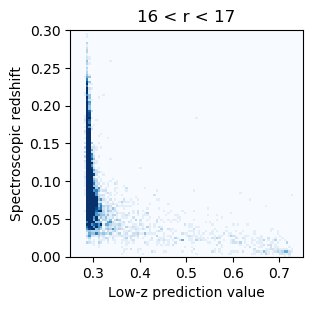

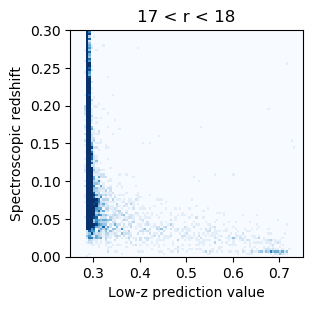

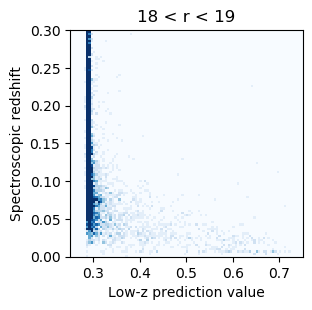

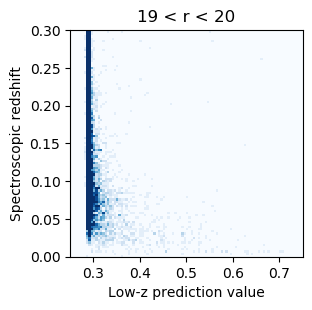

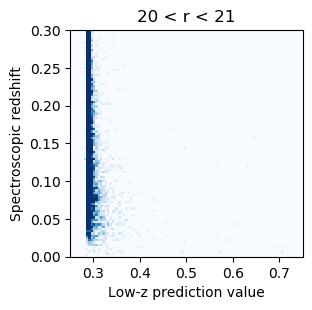

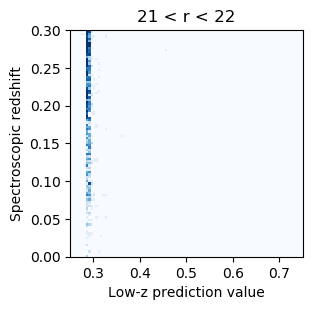

In [39]:
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    plt.figure(figsize=(3, 3), dpi=100)
    plt.hist2d(res[mag_range].pred_low_z, res[mag_range].SPEC_Z, bins=(100, 100), range=([0.25, 0.75], [0., 0.3]), vmax=10, cmap='Blues');
    plt.xlabel('Low-z prediction value')
    plt.ylabel('Spectroscopic redshift');
    plt.title(f'{r1} < r < {r2}')
    plt.show()

Is there a way to make it learn more of the fainter examples? Like perhaps we need to resample fainter things more often?

In [42]:
print('Number of low-z galaxies')
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    print(f'    {r1} < r < {r2}: {(res[mag_range].SPEC_Z < 0.03).sum()}')

Number of low-z galaxies
    16 < r < 17: 387
    17 < r < 18: 443
    18 < r < 19: 394
    19 < r < 20: 289
    20 < r < 21: 185
    21 < r < 22: 11


In [48]:
# faint = res[(res.r_mag > 19) & (res.r_mag < 20)]
# faint[faint.SPEC_Z < 0.03][['RA', 'DEC']].sample(20)

In [49]:
# faint = res[(res.r_mag > 20) & (res.r_mag < 21)]
# faint[faint.SPEC_Z < 0.03][['RA', 'DEC']].sample(20)

# Results from section 4.4 in nb 01 

In [50]:
res = pd.read_csv(f'{PATH}/results/desi-sv/results_4_4.csv')
res.sample(10)

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_low_z
27334,903426080000002346,180.098847,2.074603,20.430973,b'nsa13927',0.569955,0,False,False,1,True,0.290414
51181,903398860000004300,219.657862,1.474068,17.577112,b'nsa145372',0.177920,0,False,False,1,True,0.289175
8115,916175900000002895,228.079358,60.066615,21.101248,b'nsa165980',0.284900,0,False,False,1,True,0.289011
98175,903298270000005331,224.968179,-0.180212,16.879220,b'nsa145729',0.099228,0,False,False,1,True,0.287477
92976,915587060000003053,207.753234,43.598637,17.431484,b'nsa143856',0.137033,0,False,False,1,True,0.289854
76827,903129880000002773,335.072950,-3.267450,20.238523,b'nsa149781',0.586942,0,False,False,1,True,0.289064
73266,916028670000001713,219.055672,55.286678,16.864273,b'nsa145297',0.137064,0,False,False,1,True,0.289618
64650,903442060000003057,219.636701,2.141876,19.379930,b'nsa145372',0.353980,0,False,False,1,True,0.287321
59334,904443380000001601,248.048992,19.902589,17.145424,b'nsa147100',0.090800,0,False,False,1,True,0.288952
15607,900589100000005260,326.826147,-55.450002,17.156504,b'pgc67532',0.038729,0,False,False,1,True,0.438620


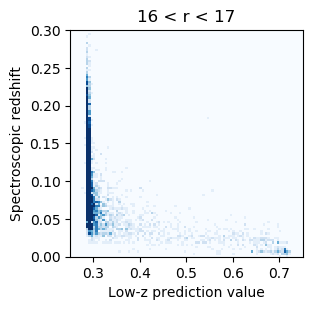

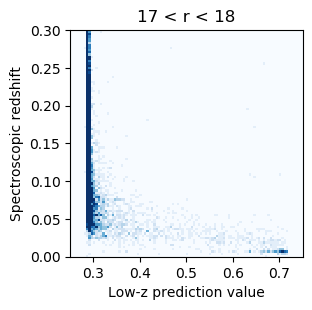

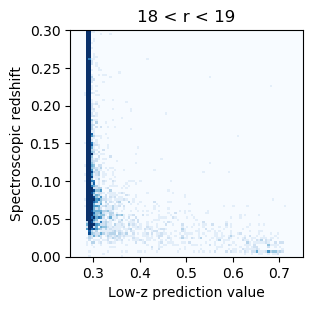

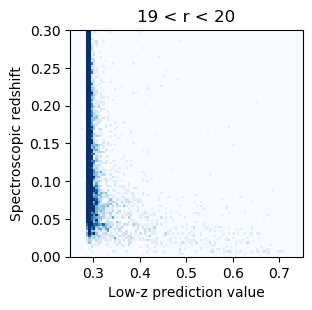

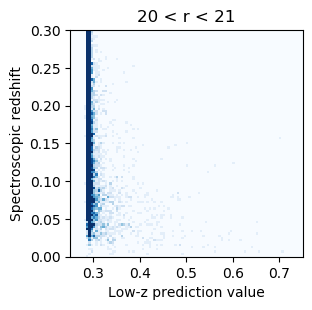

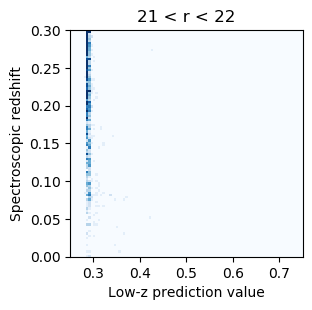

In [51]:
for r2 in range(17, 23):
    r1 = r2-1
    mag_range = (res.r_mag >= r1) & (res.r_mag < r2)
    
    plt.figure(figsize=(3, 3), dpi=100)
    plt.hist2d(res[mag_range].pred_low_z, res[mag_range].SPEC_Z, bins=(100, 100), range=([0.25, 0.75], [0., 0.3]), vmax=10, cmap='Blues');
    plt.xlabel('Low-z prediction value')
    plt.ylabel('Spectroscopic redshift');
    plt.title(f'{r1} < r < {r2}')
    plt.show()